<svg width="100" height="100" viewBox="0 0 100 100" xmlns="http://www.w3.org/2000/svg">
    <image href="https://www.rezel.net/cotcot.svg" width="100" height="100"/>
</svg>

# Rezel AI
## Workshop 02: Overfitting and feature engineering

_Authors: Denis Fouchard, Vincent Bardusco_

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Dataset import

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [4]:
data.describe()

,id,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo
count,400.000000,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000
mean,199.500000,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437
std,115.614301,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587
min,0.000000,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000
25%,99.750000,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000
50%,199.500000,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000
75%,299.250000,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000
max,399.000000,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000


In [5]:
predicted_class = "classification"
features = data.columns.to_list()
features.remove(predicted_class)
features.remove("bgr")
features.remove("bu")
print(features)

['id', 'age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']


## Data Preprocessing and cleaning

### Labelisation

In [6]:
# Get the data type of each column
data.dtypes

id                  int64
age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv                object
wc                 object
rc                 object
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object

- We can see that some of the data are not numerical. 
- We need to convert them to numerical values in order to use them in our model. 
- We will first let you implement the labelisation by yourself, and then we will use the `LabelEncoder` from `sklearn`.

In [7]:
# Get colomns with dtype object
columns_to_clean = data.select_dtypes(include=['object']).columns.to_list().copy()
print(columns_to_clean)

['rbc', 'pc', 'pcc', 'ba', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'classification']


A label encoder is a simple tool that will convert categorical data, i.e. data that are not numerical, into numerical data. We need :
- To find for each feature the different values that it can take
- To assign a numerical value to each of these values

For that, the typical way to do it is to use a dictionary. The keys of the dictionary are the different values that the feature can take, and the values of the dictionary are the numerical values that we want to assign to each of these values.

We will implement an `sklearn` transformer that will do that for us. For more details on how to implement a transformer, you can refer to the [documentation](https://scikit-learn.org/stable/developers/develop.html). What you need to know is that we need to implement two methods:
- `fit`: this method will be called when we will call the `fit` method of our transformer. It will be used to find the different values that the feature can take, and to assign a numerical value to each of these values.
- `transform`: this method will be called when we will call the `transform` method of our transformer. It will be used to convert the data.


We might also need to convert the data back to their original form. This is done using the `inverse_transform` method.

In [8]:
### Labelisation

class MyLabelEncoder():
    def __init__(self):
        self.mapping = {}
        self.inverse_mapping = {}

    def fit(self, data):
        unique_values = data.unique()
        for i, value in enumerate(unique_values):
            self.mapping[value] = i
            self.inverse_mapping[i] = value

    def transform(self, data):
        return data.apply(lambda x: self.mapping[x])

    def inverse_transform(self, data):
        return data.apply(lambda x: self.inverse_mapping[x])

In [9]:
encoder = MyLabelEncoder()

data_copy = data.copy()

for column in columns_to_clean:
    encoder.fit(data_copy[column])
    data_copy[column] = encoder.transform(data[column])

The `sklearn` library has a lot of useful built-in tools to preprocess your data in the `preprocessing` package, such as `LabelEncoder`. You can find the documentation [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing).

In [10]:
data_copy.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,7.0,50.0,1.020,4.0,0.0,0,0,0,0,...,1,1,1,1,1,0,0,0,0,0
2,2,62.0,80.0,1.010,2.0,3.0,1,0,0,0,...,2,2,1,1,0,0,1,0,1,0
3,3,48.0,70.0,1.005,4.0,0.0,1,1,1,0,...,3,3,2,0,1,0,1,1,1,0
4,4,51.0,80.0,1.010,2.0,0.0,1,0,0,0,...,4,4,3,1,1,0,0,0,0,0


In [11]:
# Label encoding
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

for column in columns_to_clean:
    data[column] = labelencoder.fit_transform(data[column])

data.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,2,1,0,0,...,32,72,34,1,4,1,0,0,0,0
1,1,7.0,50.0,1.020,4.0,0.0,2,1,0,0,...,26,56,49,0,3,1,0,0,0,0
2,2,62.0,80.0,1.010,2.0,3.0,1,1,0,0,...,19,70,49,0,4,1,1,0,1,0
3,3,48.0,70.0,1.005,4.0,0.0,1,0,1,0,...,20,62,19,1,3,1,1,1,1,0
4,4,51.0,80.0,1.010,2.0,0.0,1,1,0,0,...,23,68,27,0,3,1,0,0,0,0


### NaN handling

In [12]:
## NaN ratio
print("Feature        NaN ratio")
print(data.isnull().mean().sort_index())


Feature        NaN ratio
age               0.0225
al                0.1150
ane               0.0000
appet             0.0000
ba                0.0000
bgr               0.1100
bp                0.0300
bu                0.0475
cad               0.0000
classification    0.0000
dm                0.0000
hemo              0.1300
htn               0.0000
id                0.0000
pc                0.0000
pcc               0.0000
pcv               0.0000
pe                0.0000
pot               0.2200
rbc               0.0000
rc                0.0000
sc                0.0425
sg                0.1175
sod               0.2175
su                0.1225
wc                0.0000
dtype: float64


In [13]:
data.dropna(inplace=True)
data.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
3,3,48.0,70.0,1.005,4.0,0.0,1,0,1,0,...,20,62,19,1,3,1,1,1,1,0
5,5,60.0,90.0,1.015,3.0,0.0,2,2,0,0,...,27,72,25,1,4,1,0,1,0,0
6,6,68.0,70.0,1.010,0.0,0.0,2,1,0,0,...,24,92,49,0,3,1,0,0,0,0
9,9,53.0,90.0,1.020,2.0,0.0,0,0,1,0,...,17,18,17,1,4,1,1,0,1,0
11,11,63.0,70.0,1.010,3.0,0.0,0,0,1,0,...,20,43,18,1,4,1,1,1,0,0


## Train / Test split

In [14]:
from sklearn.model_selection import train_test_split
y = data[predicted_class]
X = data.drop([predicted_class, 'bgr', 'bu'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, shuffle=True, random_state=42)

## Feature selection and reduction

We will now focus on trying to understand which of the features are relevant for our model. For now, don't try to understand what the different methods do, we will explain them later.
What we want to do is to plot the explained variance ratio of each feature, that is to say, its importance relative to the other features. 

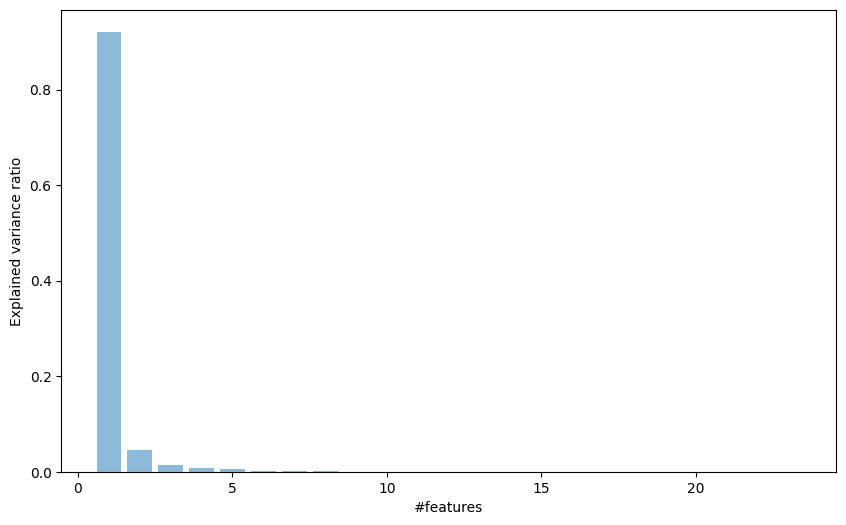

In [15]:
## Explained variance matrix
from sklearn.decomposition import PCA
mystery = PCA(n_components=len(features))
mystery.fit(X_train)

explained_variance = mystery.explained_variance_ratio_

#Plot explained variance and cumulative explained variance

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.5, align='center', label='individual explained variance')
plt.xlabel('#features')
plt.ylabel('Explained variance ratio')
plt.show()

We clearly see that most of the variance of the data, that is to say the information, is contained in the first three features, and that the other features are not really useful. We will therefore only keep the first three features.
What is intersting is to plot the cumulative variance explained by the first $k$ components.

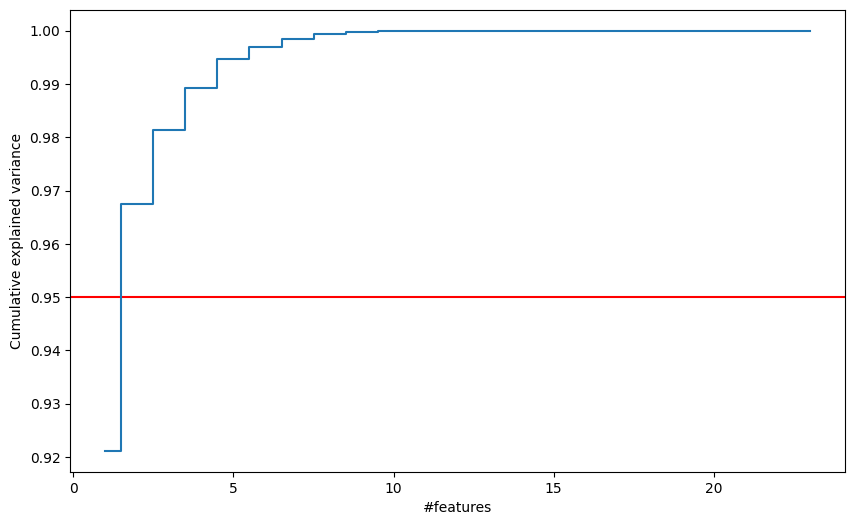

In [16]:
plt.figure(figsize=(10, 6))
plt.axhline(y=0.95, color='r', linestyle='-')
plt.step(range(1, len(explained_variance)+1), 
         np.cumsum(explained_variance), 
         where='mid', 
         label='cumulative explained variance')
plt.xlabel('#features')
plt.ylabel('Cumulative explained variance')
plt.show()

For those who are more into math, here is a rapid explaination of what a PCA is.

### Principal Component Analysis (PCA)

A Principal Component Analysis (PCA) is a method that will allow us to reduce the dimensionality of our data. It will find a new set of features that are linear combinations of the original features, and that will contain most of the information of the original features. The new features are called the principal components.

Mathematically, the PCA will find a new set of features $X'$ such that:
- The features of $X'$ are linear combinations of the features of $X$
- The features of $X'$ are orthogonal, i.e. they are not correlated
- The features of $X'$ are sorted by decreasing variance, i.e. the first feature of $X'$ contains the most information, the second feature of $X'$ contains the second most information, etc.

The PCA is a very useful tool to reduce the dimensionality of your data, and to find the most important features. It is also very useful to visualize your data, as we will see later.
The PCA works by first decomposing the data matrix into what we call the *Singular Value Decomposition (SVD)*. 

*Definition - Singular Value*
For a given matrix $X$, a singular value is eigenvalue of $X^T X$.

The SVD of a matrix $X$ is defined as:

$$X = U \Sigma V^T$$

where $U$ and $V$ are orthogonal matrices, and $\Sigma$ is a diagonal matrix. 
- The columns of $U$ are called the left-singular vectors of $X$
- The columns of $V$ are called the right-singular vectors of $X$
- The diagonal elements of $\Sigma$ are called the singular values of $X$

What interests us is the matrix $\Sigma$, as it will allow us to visualize the importance of each feature. The diagonal elements of $\Sigma$ are the singular values of $X$, and they are sorted by decreasing value. The first singular value is the largest, and the last singular value is the smallest. The first singular value is the variance of the first principal component, the second singular value is the variance of the second principal component, etc.


As we found that the first three features were the most important, we will only keep them. We use the PCA class from sklearn to transform our data.
As always, we **ONLY PERFOM THE FIT ON THE TRAINING DATA**. We then use the fitted PCA to transform both the training and the test data.

In [17]:
pca = PCA(n_components=3)
pca.fit(X_train)
X_train_pca = pca.transform(X_train) # ONLY PERFORM ON TRAINING DATA !!!!!!!
X_test_pca = pca.transform(X_test)

# Get the name of the feature with the highest variance
max_variance_feature = features[np.argmax(pca.components_[0])]
print("The feature with the highest variance is: " + max_variance_feature)

The feature with the highest variance is: bp


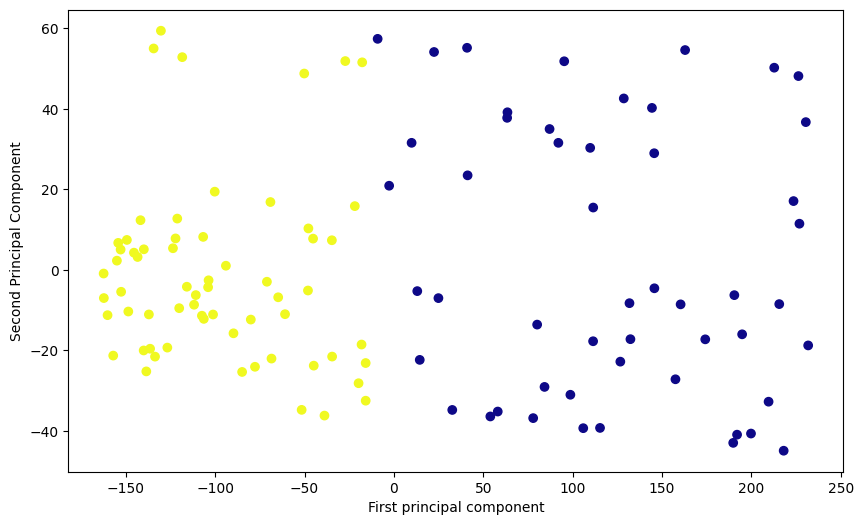

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.show()

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression()
model.fit(X_train_pca, y_train)
y_pred = model.predict(X_test_pca)
y_pred = np.round(y_pred)
print(y_pred)
print(accuracy_score(y_test, y_pred))

[2 0 0 2 0 2 0 2 2 2 2 0 0 2 2 2 2 0 2 2 2 2 2 2 2 0 2 0 2 0 2 0 2 0 0 2 2
 2 0 2 2 2 2 0 2 2 2 0 2 0 2 2 2 0 0 0 2 2 0 0 0 2 2 0 2 0 2 0 0 0 0 2 2 2
 0 2 2 2 0 0 0 0 0 2 2 2 0 2 2 0 0 2 2 0 2 0 2 2 2 0 0 0 0 2 2 2 2 0 0 2 2
 0 0 2]
0.9649122807017544


Without PCA :

In [20]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)
print(accuracy_score(y_test, y_pred))

0.9649122807017544


/Users/df/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


We can plot the final accuracy of our model as a function of the number of features that we keep. We see that we can keep only the first three features, and still have a good accuracy.

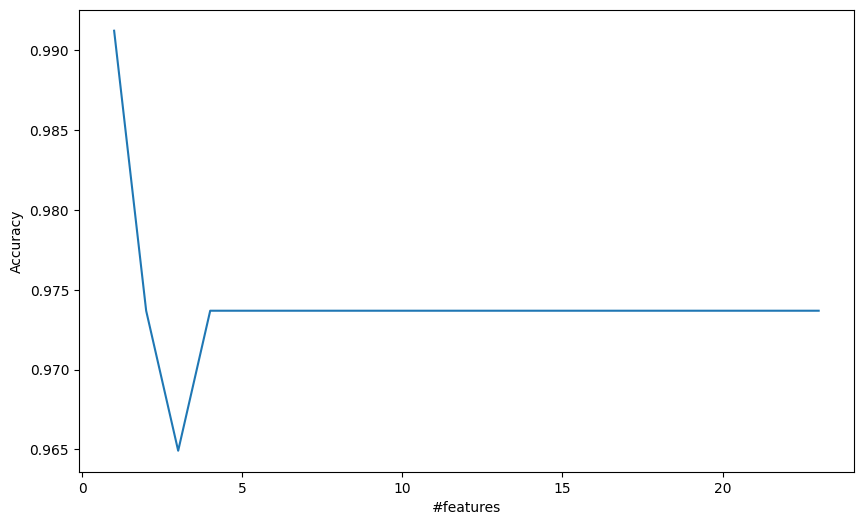

In [21]:
accuracy = []
for i in range(1, len(features)+1):
    pca = PCA(n_components=i)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train) # ONLY PERFORM ON TRAINING DATA !!!!!!!
    X_test_pca = pca.transform(X_test)
    model = LogisticRegression()
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    y_pred = np.round(y_pred)
    accuracy.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(features)+1), accuracy)
plt.xlabel('#features')
plt.ylabel('Accuracy')
plt.show()